# Converting between Ising and flux schedules for multiqubit systems

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import cas as cas
import importlib
import pickle

This notebook includes examples on how to calculate Ising schedules for given fluxes, and how to calculate fluxes for given Ising schedules.

Here we consider a chain of two qubit that are coupled via two tunable couplers and another chain of two qubits that are coupled via another Qubit (CSFQ).
First, let us create the qubit, coupler and Qubit as a coupler objects, using typical parameters of Indus.
Note that here we use symmetric junctions with `d=0`.

In [2]:
i_c = 230; c_shunt = 50; c_z = 4.4; lq = 480; alpha = 0.4; d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d, 5, 10, 10)

i_sigma = 565; c_sigma = 11; lc = 580; d = 0.0
coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)

Let us define `elements1` for the chain with a coupler and `elements2` for the chain with a qubit as a coupler

In [3]:
elements = [qubit0, coupler01, qubit1, coupler12, qubit2]

Having our qubits and coupler in this list, we will now have to set the mutuals between them to construct the mutual matrix `m_mat` between them.
For that, if `elements[i]` and `elements[j]` circuit elements are coupled via a mutual inductance of `m`, then for the mutual matrix we should have `m_mat[i, j] = m_mat[j, i] = -m` (notice the negative sign).
Note that the size of (both of axis of the) mutual matrix is the same as the size of the `elements`.
Therefore for a chain configuration we have:

In [4]:
m = 65; m_mat = np.zeros((5, 5));

m_mat[0, 1] = m; m_mat[1, 2] = m; m_mat[2, 3] = m; m_mat[3, 4] = m;

m_mat = -(m_mat + m_mat.T)

In [5]:
m_mat

array([[ -0., -65.,  -0.,  -0.,  -0.],
       [-65.,  -0., -65.,  -0.,  -0.],
       [ -0., -65.,  -0., -65.,  -0.],
       [ -0.,  -0., -65.,  -0., -65.],
       [ -0.,  -0.,  -0., -65.,  -0.]])

The last part is to choose a truncation size for the circuit elements.
For the couplers we can get away with keeping less number of levels but when we use qubit as coupler, then we should in principle keep same number of levels for all the circuit elments. But here let us first keep these to be same and see if it makes any difference.

In [6]:
trunc_vec = np.array([6, 3, 6, 3, 6])

We have now all the required elements to create our circuit object which we'll use for all the calculations

In [7]:
circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

## Calculating Ising schedules for given circuit biases

To calculate the schedules using the circuit biases, we first have to construct a dictionary of the circuit fluxes.
This dictionary will have a key named `points` which simply is the number of points used for the flux schedules.
For circuit element i (`elements[i]`), the x and z biases should have keys of `"phix_i"` and `"phiz_i"` respectively.
This keys then are assigned to an array of flux points.
The input for circuit biases are phase, i.e., $\varphi = \frac{\Phi}{\Phi_0}2\pi$ where $\varphi$ is the phase and $\Phi$ is the magnetic flux.

Note that we use the annealing region near $\Phi_z = 0$, and NOT $\Phi_z = \Phi_0/2$.
Below we use some simple circuit biases that change linearly during the anneal.

Here, we are trying to probe where the CSFQ can be used as a coupler. To do this, we park both the qubits at the end of the anneal and sweep $\phi_x$ of the coupler (CSFQ here).

In [8]:
phi_dict = {}; pts = 20;
s = np.linspace(0, 1, pts)
phi_dict["points"] = pts

phi_dict["phix_0"] = np.linspace(0.73, 1, pts)*2*np.pi
phi_dict["phix_1"] = np.linspace(0.5, 1, pts)*2*np.pi
phi_dict["phix_2"] = np.linspace(0.73, 0.85, pts)*2*np.pi
phi_dict["phix_3"] = np.linspace(0.5, 0.85, pts)*2*np.pi
phi_dict["phix_4"] = np.linspace(0.75, 1, pts)*2*np.pi

phi_dict["phiz_0"] = np.linspace(0.0, 0.002, pts)*2*np.pi
phi_dict["phiz_1"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_2"] = np.linspace(0, 0.001, pts)*2*np.pi
phi_dict["phiz_3"] = np.linspace(0, 0, pts)*2*np.pi
phi_dict["phiz_4"] = np.linspace(0, 0.002, pts)*2*np.pi

In [9]:
spectrum_test = circuit.calculate_spectrum(phi_dict, levels=10)

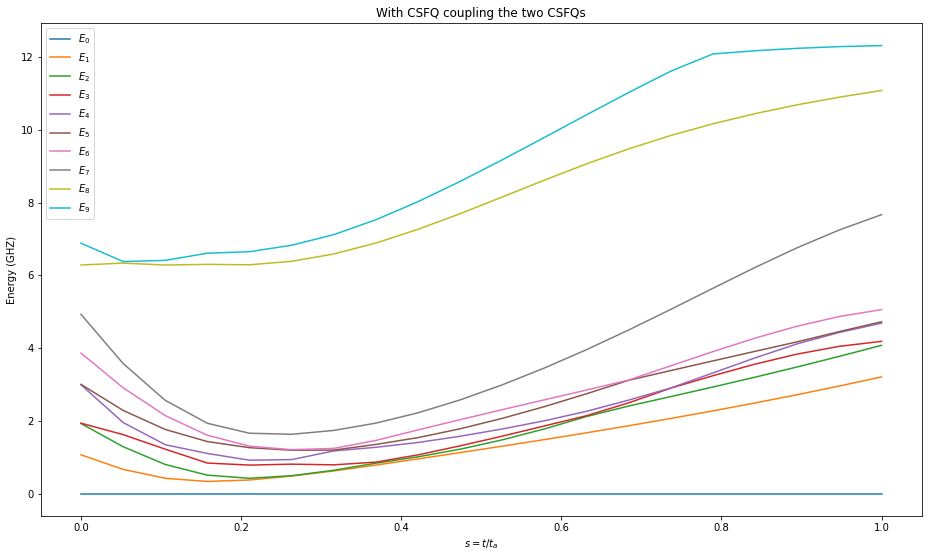

In [10]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((13, 8))

for i in range(1):
    ax1 = plt.subplot(1, 1, i+1)
    
    plt.plot(s, spectrum_test[:,0]/2/np.pi, label=r"$E_0$", color="C0")
    plt.plot(s, spectrum_test[:,1]/2/np.pi, label=r"$E_1$", color="C1")
    plt.plot(s, spectrum_test[:,2]/2/np.pi, label=r"$E_2$", color="C2")
    plt.plot(s, spectrum_test[:,3]/2/np.pi, label=r"$E_3$", color="C3")
    plt.plot(s, spectrum_test[:,4]/2/np.pi, label=r"$E_4$", color="C4")
    plt.plot(s, spectrum_test[:,5]/2/np.pi, label=r"$E_5$", color="C5")
    plt.plot(s, spectrum_test[:,6]/2/np.pi, label=r"$E_6$", color="C6")
    plt.plot(s, spectrum_test[:,7]/2/np.pi, label=r"$E_7$", color="C7")
    plt.plot(s, spectrum_test[:,8]/2/np.pi, label=r"$E_8$", color="C8")
    plt.plot(s, spectrum_test[:,9]/2/np.pi, label=r"$E_9$", color="C9")
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Energy (GHZ)")
    plt.legend()
    plt.title("With CSFQ coupling the two CSFQs")

    
plt.suptitle("")
plt.tight_layout()
plt.show()

## get_ising_sw gives individual qubit ising coefficients $X_i$, $Z_i$ and $Z_{i}Z_{i+1}$

In [16]:
%%time
ising_sw_dict = circuit.get_ising_sw(phi_dict, verbose=True)

CPU times: user 16min 28s, sys: 1min 28s, total: 17min 57s
Wall time: 5min 10s


In [17]:
%%time
ising_pwsw_dict = circuit.get_ising_pwsw(phi_dict, verbose=True)

calculating qubit isings for qubit 1 of 3
calculating qubit isings for qubit 2 of 3
calculating qubit isings for qubit 3 of 3
calculating coupling strength for coupler 1 of 2
calculating coupling strength for coupler 2 of 2
CPU times: user 2min 55s, sys: 47.2 s, total: 3min 42s
Wall time: 1min 10s


In [18]:
ising_pwsw_dict.keys()

dict_keys(['x_0', 'z_0', 'x_1', 'z_1', 'x_2', 'z_2', 'zz_0,1', 'zz_1,2', 'points'])

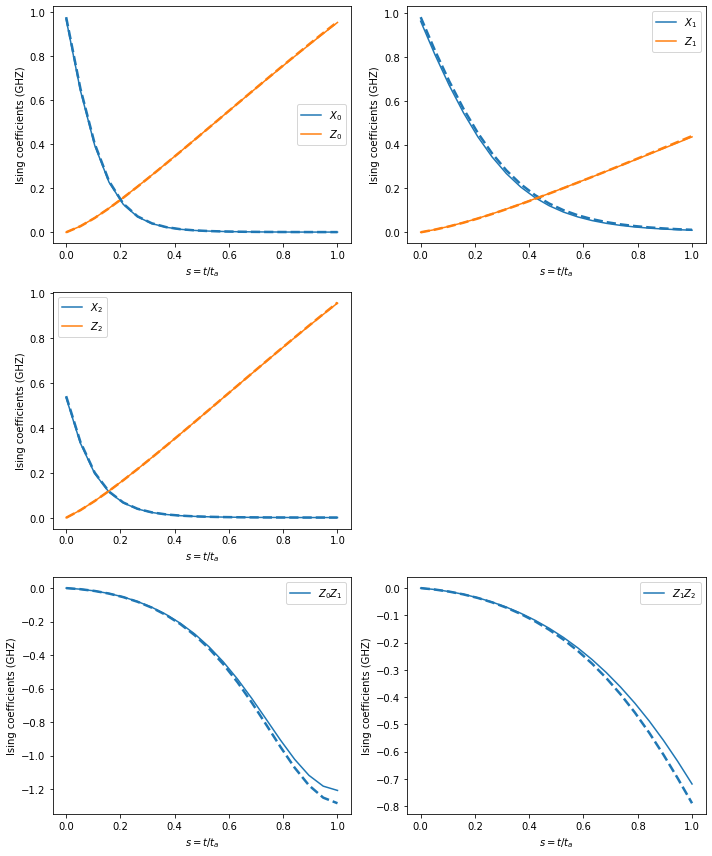

In [19]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 12))

for i in range(3):
    ax1 = plt.subplot(3, 2, i+1)
    
    plt.plot(s, ising_sw_dict["x_"+str(i)]/2/np.pi, label=r"$X_{0:d}$".format(i), color="C0")
    plt.plot(s, ising_sw_dict["z_"+str(i)]/2/np.pi, label=r"$Z_{0:d}$".format(i), color="C1")
    
    plt.plot(s, ising_pwsw_dict["x_"+str(i)]/2/np.pi, color="C0", ls='--', lw=2.5 )
    plt.plot(s, ising_pwsw_dict["z_"+str(i)]/2/np.pi, color="C1", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
labels = [[0, 1], [1, 2]]
for i in range(2):
    ax2 = plt.subplot(3, 2, i+5)
    
    plt.plot(s, ising_sw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]))
    
    plt.plot(s, ising_pwsw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, color="C0", ls='--', lw=2.5 )
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()
    
plt.tight_layout()
plt.show()

## Using get_ising_sw_all which generates all the XX, YY, ZZ couplings between any qubit pairs in the elements

In [9]:
%%time
ising_sw_dict = circuit.get_ising_sw_all(phi_dict, verbose=True)

CPU times: user 17min 22s, sys: 1min 23s, total: 18min 45s
Wall time: 5min 8s


In [10]:
ising_sw_dict

{'points': 20,
 'x_0': array([6.08302365e+00, 4.04640775e+00, 2.48199427e+00, 1.43026011e+00,
        7.97642463e-01, 4.42373828e-01, 2.48697639e-01, 1.43490493e-01,
        8.56563723e-02, 5.31973942e-02, 3.45067657e-02, 2.34392886e-02,
        1.66989405e-02, 1.24855205e-02, 9.79517927e-03, 8.05629435e-03,
        6.93782268e-03, 6.24717511e-03, 5.87521645e-03, 5.76686166e-03]),
 'z_0': array([1.43564861e-13, 1.74758392e-01, 4.10427431e-01, 6.87923650e-01,
        9.90060801e-01, 1.30689461e+00, 1.63336400e+00, 1.96653889e+00,
        2.30436688e+00, 2.64523346e+00, 2.98779494e+00, 3.33089484e+00,
        3.67351381e+00, 4.01473980e+00, 4.35375219e+00, 4.68981256e+00,
        5.02225080e+00, 5.35043571e+00, 5.67372443e+00, 5.99139470e+00]),
 'x_1': array([6.05415981, 5.09452143, 4.2139517 , 3.42653073, 2.74160481,
        2.16220923, 1.68482439, 1.30055161, 0.9971647 , 0.76125073,
        0.57986774, 0.44152915, 0.33660404, 0.2573265 , 0.19759503,
        0.15268972, 0.11898411, 0.09

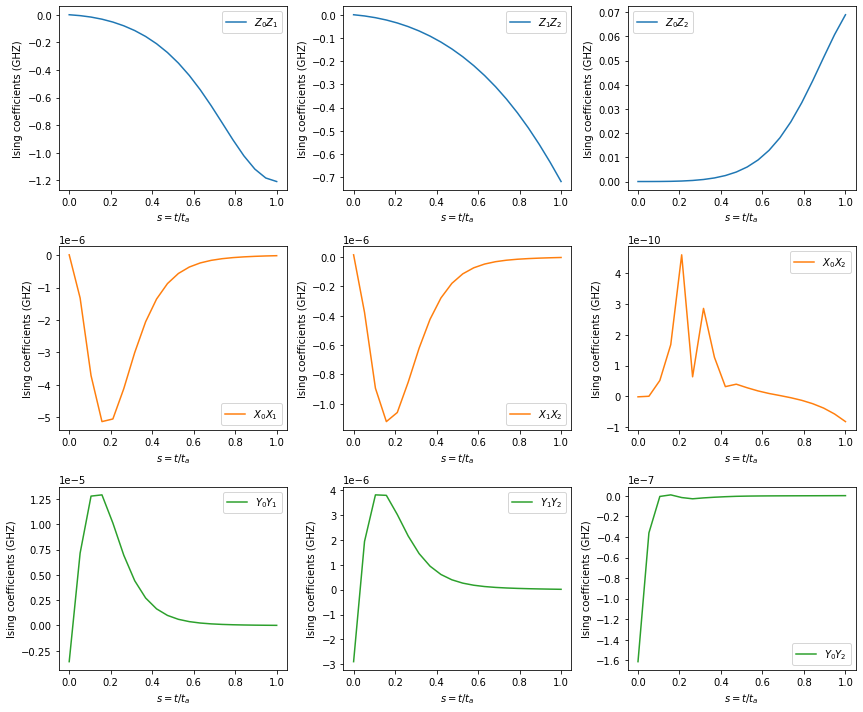

In [11]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((12, 10))

labels = [[0, 1], [1, 2],[0, 2]]
for i in range(3):
    ax2 = plt.subplot(3, 3, i+1)
    
    plt.plot(s, ising_sw_dict["zz_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$Z_{0:d}Z_{1:d}$".format(labels[i][0], labels[i][1]),ls="-")
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()

    
for i in range(3):
    ax2 = plt.subplot(3, 3, i+4)
     
    plt.plot(s, ising_sw_dict["xx_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$X_{0:d}X_{1:d}$".format(labels[i][0], labels[i][1]),ls="-",color= "C1")
        
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()


for i in range(3):
    ax2 = plt.subplot(3, 3, i+7)
    
    plt.plot(s, ising_sw_dict["yy_"+str(labels[i][0])+','+str(labels[i][1])]/2/np.pi, 
             label=r"$Y_{0:d}Y_{1:d}$".format(labels[i][0], labels[i][1]),ls="-",color=  "C2")
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"Ising coefficients (GHZ)")
    plt.legend()



plt.tight_layout()
plt.show()